#### 基于规则

In [2]:
customer = """
customer = sub verb obj
sub = 我 | 她 | 他 | 我们 | 他们
verb = 想去 | 旅行想去
obj = 韩国 | 美国 | 日本 | 中国
"""

In [3]:
service = """
service = 寒暄 自我介绍 询问 具体城市 结尾
寒暄 = 称谓 打招呼 。 | 打招呼 。
称谓 = 人称 ，
人称 = 先生 | 女士 | 小朋友
打招呼 = 您好 | 你好
自我介绍 = 我是 名字 。
名字 = Sunny | Alex | Susan
询问 = 请问您是想去 | 您是想去
具体城市 = 日本东京 | 韩国首尔 | 日本大阪 | 日本北海道 | 日本看樱花 | 韩国普吉岛 | 美国旧金山 | 美国纽约 | 中国香港 | 中国澳门 | 中国台湾
结尾 = 吗？
"""

In [4]:
customer

'\ncustomer = sub verb obj\nsub = 我 | 她 | 他 | 我们 | 他们\nverb = 想去 | 旅行想去\nobj = 韩国 | 美国 | 日本 | 中国\n'

In [5]:
def create_grammar(grammar_str, split='=', line_split='\n'):
    grammar = {}    
    for line in grammar_str.split(line_split):
        if not line.strip():
            continue        
        exp,stmt = line.split(split)
        grammar[exp.strip()] = [s.split() for s in stmt.split('|')]
    return grammar        

In [6]:
customer_gram = create_grammar(customer)
customer_gram

{'customer': [['sub', 'verb', 'obj']],
 'sub': [['我'], ['她'], ['他'], ['我们'], ['他们']],
 'verb': [['想去'], ['旅行想去']],
 'obj': [['韩国'], ['美国'], ['日本'], ['中国']]}

In [7]:
service_gram = create_grammar(service)
service_gram

{'service': [['寒暄', '自我介绍', '询问', '具体城市', '结尾']],
 '寒暄': [['称谓', '打招呼', '。'], ['打招呼', '。']],
 '称谓': [['人称', '，']],
 '人称': [['先生'], ['女士'], ['小朋友']],
 '打招呼': [['您好'], ['你好']],
 '自我介绍': [['我是', '名字', '。']],
 '名字': [['Sunny'], ['Alex'], ['Susan']],
 '询问': [['请问您是想去'], ['您是想去']],
 '具体城市': [['日本东京'],
  ['韩国首尔'],
  ['日本大阪'],
  ['日本北海道'],
  ['日本看樱花'],
  ['韩国普吉岛'],
  ['美国旧金山'],
  ['美国纽约'],
  ['中国香港'],
  ['中国澳门'],
  ['中国台湾']],
 '结尾': [['吗？']]}

In [8]:
from random import choice
def generate(gram, target):
    if target not in gram:
        return target
    res = [generate(gram, t) for t in choice(gram[target])]
    return ''.join([s for s in res if s != 'null'])

In [9]:
for i in range(10):
    print(generate(customer_gram,'customer'))

我们旅行想去美国
她想去美国
她想去韩国
他想去美国
我们旅行想去美国
他想去韩国
他们想去日本
我们想去中国
她想去韩国
我们旅行想去中国


In [10]:
for i in range(10):
    print(generate(service_gram,'service'))

你好。我是Susan。请问您是想去美国纽约吗？
你好。我是Alex。请问您是想去中国香港吗？
女士，您好。我是Alex。请问您是想去中国香港吗？
女士，您好。我是Susan。您是想去韩国普吉岛吗？
你好。我是Sunny。您是想去日本东京吗？
您好。我是Alex。您是想去韩国普吉岛吗？
你好。我是Sunny。您是想去日本东京吗？
女士，你好。我是Alex。请问您是想去中国澳门吗？
你好。我是Sunny。您是想去中国台湾吗？
你好。我是Alex。请问您是想去日本大阪吗？


### Language Model

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from operator import add,mul
import re
import jieba
from collections import Counter

In [12]:
PATH=r'E:\NLP\dataset'
movie_comments = pd.read_csv(PATH + r'\movie_comments.csv')
movie_comments.head(10)

d:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1
5,6,https://movie.douban.com/subject/26363254/,战狼2,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,7,https://movie.douban.com/subject/26363254/,战狼2,脑子是个好东西，希望编剧们都能有。,2
7,8,https://movie.douban.com/subject/26363254/,战狼2,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,9,https://movie.douban.com/subject/26363254/,战狼2,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,10,https://movie.douban.com/subject/26363254/,战狼2,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


In [13]:
comments = movie_comments['comment'].tolist()
comments[:5]

['吴京意淫到了脑残的地步，看了恶心想吐',
 '首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮番上场，视物理逻辑于不顾，不得不说有钱真好，随意胡闹',
 '吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋律，为了煽情而煽情，让人觉得他是个大做作、大谎言家。（7.29更新）片子整体不如湄公河行动，1.整体不够流畅，编剧有毒，台词尴尬；2.刻意做作的主旋律煽情显得如此不合时宜而又多余。',
 '凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。',
 '中二得很']

In [14]:
def clean(string):
    cleaned = re.findall('\w+',string)
    return ''.join(cleaned)

def cut(string):
    return jieba.cut(string)

In [15]:
comments_clean = [clean(str(s)) for s in comments][:10000]

In [16]:
comments_clean[:5]

['吴京意淫到了脑残的地步看了恶心想吐',
 '首映礼看的太恐怖了这个电影不讲道理的完全就是吴京在实现他这个小粉红的英雄梦各种装备轮番上场视物理逻辑于不顾不得不说有钱真好随意胡闹',
 '吴京的炒作水平不输冯小刚但小刚至少不会用主旋律来炒作吴京让人看了不舒服为了主旋律而主旋律为了煽情而煽情让人觉得他是个大做作大谎言家729更新片子整体不如湄公河行动1整体不够流畅编剧有毒台词尴尬2刻意做作的主旋律煽情显得如此不合时宜而又多余',
 '凭良心说好看到不像战狼1的续集完虐湄公河行动',
 '中二得很']

In [17]:
comment_words_list = [list(cut(s)) for s in comments_clean]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 1.686 seconds.
Prefix dict has been built succesfully.


In [18]:
TOKENS = reduce(add,comment_words_list)

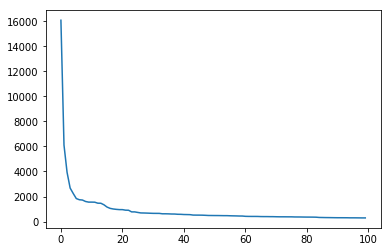

In [19]:
words_count = Counter(TOKENS)
freq = [f for w,f in words_count.most_common(100)]
x=[i for i in range(100)]
plt.plot(x,freq)

In [20]:
def prob_1(word):
    if word in words_count:
        return words_count[word] / len(TOKENS)
    else:
        return 1 / len(TOKENS)

In [21]:
TOKENS_2_GRAM = [reduce(add,TOKENS[i:i+2]) for i in range(len(TOKENS)-2)]
words_count_2 = Counter(TOKENS_2_GRAM)

In [22]:
def prob_2(word1,word2):
    if word1 + word2 in words_count_2:
        return words_count_2[word1 + word2] / len(TOKENS_2_GRAM)
    else:
        return 1 / len(TOKENS_2_GRAM)

In [23]:
def get_prob(sentence):
    words = list(cut(clean(sentence)))
    prob_list = [prob_2(words[i], words[i+1]) / prob_1(words[i]) for i in range(len(words)-1)]
    return reduce(mul, prob_list)

In [24]:
def generate_best(gram,target,n):
    sen = {}
    sentence = [generate(gram,target) for i in range(n)]
    for s in sentence:
        sen[s] = get_prob(s)
    sen_sorted = sorted(sen.items(), key=lambda x: x[1])
    print(sen_sorted)
    return sen_sorted[-1]

In [25]:
exp_grammar = """
exp = noun_phrase verb_phrase
noun_phrase = Article Adj* noun
Adj* = null | Adj Adj*
verb_phrase = verb noun_phrase
Article = 一个 | 这个
noun = 女人 | 篮球 | 桌子 | 小猫 
verb = 看着 | 坐在 | 听着 |看见
Adj = 蓝色的 | 好看的 | 小小的
"""

In [34]:
exp_gram = create_grammar(exp_grammar)

In [36]:
generate_best(exp_gram,'exp',10)

[('这个小小的好看的蓝色的桌子坐在这个蓝色的小小的蓝色的小猫', 1.0058540979427654e-27), ('一个小小的桌子看见一个好看的小小的小小的好看的蓝色的桌子', 1.9989903843173363e-24), ('一个好看的蓝色的小猫看着一个小猫', 2.346695406673416e-18), ('一个蓝色的蓝色的桌子坐在一个篮球', 3.822890327755557e-17), ('一个小小的蓝色的小小的小猫听着这个女人', 1.8332052524946715e-16), ('一个小小的蓝色的桌子看见这个女人', 6.70703345335147e-13), ('一个篮球看着一个好看的女人', 1.3218490398687677e-12), ('一个小猫看着这个好看的女人', 4.734670328208447e-12), ('一个小猫看见一个好看的女人', 6.091999922873452e-12), ('这个小小的小猫看见一个小猫', 1.8889724046564684e-08)]


('这个小小的小猫看见一个小猫', 1.8889724046564684e-08)